Train/Val/Test shapes: (400, 2) (100, 2) (500, 2)
MLP earlystop val AUROC: 1.0000
L1 1.0e-06: val AUROC 1.0000 spars {'0.weight': 0.0, '2.weight': 0.0}
L1 3.0e-06: val AUROC 1.0000 spars {'0.weight': 0.0, '2.weight': 0.0}
L1 1.0e-05: val AUROC 1.0000 spars {'0.weight': 0.0, '2.weight': 0.0}
L1 3.0e-05: val AUROC 1.0000 spars {'0.weight': 0.0, '2.weight': 0.0}
L1 1.0e-04: val AUROC 1.0000 spars {'0.weight': 0.0, '2.weight': 0.0}
L1 3.0e-04: val AUROC 1.0000 spars {'0.weight': 0.0, '2.weight': 0.0}
L2 wd=1.0e-06: val AUROC 1.0000
L2 wd=3.0e-06: val AUROC 1.0000
L2 wd=1.0e-05: val AUROC 1.0000
L2 wd=3.0e-05: val AUROC 1.0000
L2 wd=1.0e-04: val AUROC 1.0000
L2 wd=1.0e-03: val AUROC 0.9992
L2 wd=1.0e-02: val AUROC 0.9796
Selected L2 weight_decay: 1e-06
LogReg val AUROC: 0.9663999999999999

Accuracy table:
noise                  noise_0.1  noise_0.2  noise_0.3
model                                                 
LogReg_poly2               0.894      0.870      0.856
MLP_L1_lambda_1.0e-06  

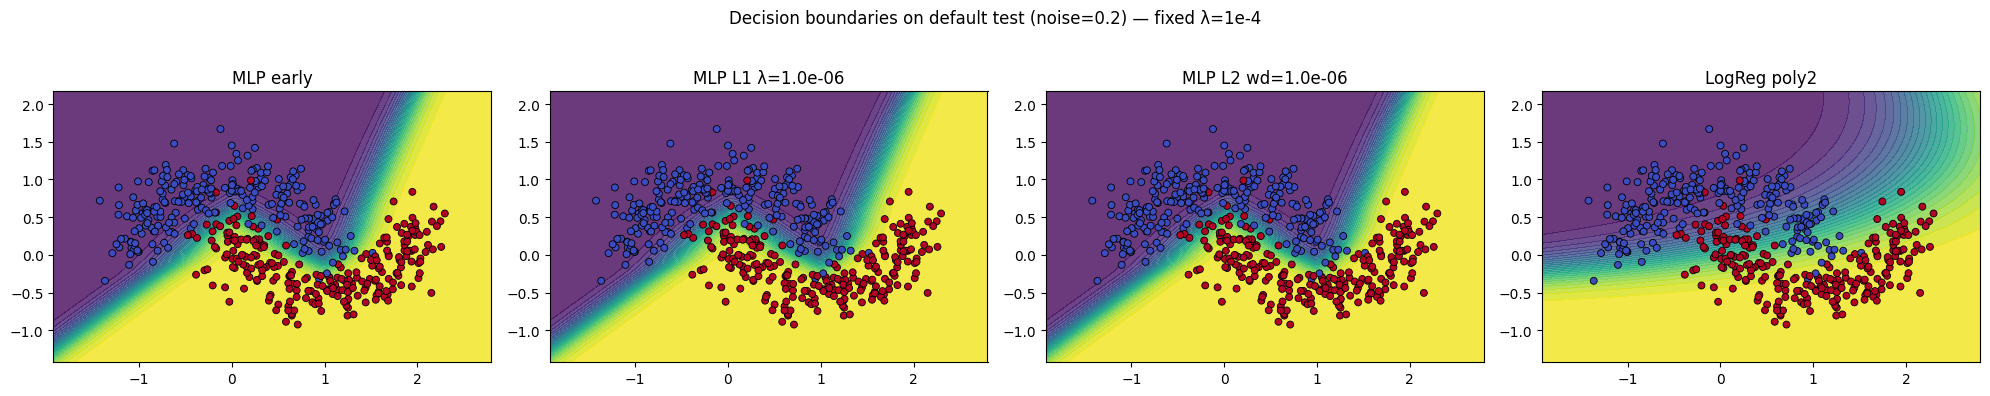


Imbalanced-training results (evaluated on balanced tests):
                           accuracy                         auroc            \
noise                     noise_0.1 noise_0.2 noise_0.3 noise_0.1 noise_0.2   
model                                                                         
LogReg_poly2_imb              0.894     0.852     0.854  0.969648  0.945040   
MLP_L1_lambda_1.0e-06_imb     0.992     0.948     0.908  0.999744  0.990400   
MLP_L2_wd_1.0e-06_imb         0.992     0.960     0.912  0.999888  0.991600   
MLP_early_imb                 0.994     0.950     0.910  0.999856  0.991424   

                                     
noise                     noise_0.3  
model                                
LogReg_poly2_imb           0.942016  
MLP_L1_lambda_1.0e-06_imb  0.976576  
MLP_L2_wd_1.0e-06_imb      0.976592  
MLP_early_imb              0.976800  
L1 regularization:
- For small λ, performance is unaffected (AUROC ≈ 1.0) and no weights are pruned.
- At λ = 1e-02, a f

In [5]:
import math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cpu")
hidden_dim = 32

def make_moons(n_samples=500, noise=0.2, seed=None):
    rng = np.random.RandomState(seed) if seed is not None else np.random
    n_out = n_samples // 2
    n_in = n_samples - n_out
    t1 = rng.uniform(0, math.pi, n_out)
    x1 = np.vstack([np.cos(t1), np.sin(t1)]).T
    t2 = rng.uniform(0, math.pi, n_in)
    x2 = np.vstack([1 - np.cos(t2), -np.sin(t2) + 0.5]).T
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n_out, dtype=int), np.ones(n_in, dtype=int)])
    X += rng.normal(scale=noise, size=X.shape)
    perm = rng.permutation(n_samples)
    return X[perm], y[perm]

def split_standardize(X_full, y_full, test_size=0.2, seed=SEED):
    X_tr, X_val, y_tr, y_val = train_test_split(X_full, y_full, test_size=test_size,
                                                random_state=seed, stratify=y_full)
    scaler = StandardScaler().fit(X_tr)
    return X_tr, X_val, y_tr, y_val, scaler

def build_mlp(input_dim=2, hidden_dim=32):
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    )

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def layerwise_sparsity(model, threshold=1e-6):
    spars = {}
    for name, p in model.named_parameters():
        if 'weight' in name:
            arr = p.detach().cpu().numpy()
            spars[name] = float((np.abs(arr) <= threshold).mean())
    return spars

def train_nn(model, X_train, y_train, X_val, y_val, lr=1e-3, weight_decay=0.0, l1_lambda=0.0,
             max_epochs=5000, patience=50, batch_size=64, verbose=False):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.BCELoss()
    Xtr = torch.tensor(X_train, dtype=torch.float32).to(device)
    ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32).to(device)
    Xv = torch.tensor(X_val, dtype=torch.float32).to(device)
    yv = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    best_auc = -np.inf
    best_state = None
    no_improve = 0
    hist = {'train_loss': [], 'val_auc': []}
    for epoch in range(1, max_epochs+1):
        
        total_loss = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            preds = model(xb)
            loss = crit(preds, yb)
            if l1_lambda > 0:
                l1 = 0.0
                for p in model.parameters():
                    l1 = l1 + p.abs().sum()
                loss = loss + l1_lambda * l1
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(loader.dataset)
        
        with torch.no_grad():
            pv = model(Xv).cpu().numpy().ravel()
        val_auc = roc_auc_score(y_val, pv)
        hist['train_loss'].append(avg_loss)
        hist['val_auc'].append(val_auc)
        if val_auc > best_auc + 1e-8:
            best_auc = val_auc
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= patience:
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

def predict_proba_torch(model, X):
    model = model.to(device)
    model.eval()
    Xt = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        p = model(Xt).cpu().numpy().ravel()
    return p

# Data generation 
n_samples = 500

# Training full (balanced) noise=0.2
X_train_full, y_train_full = make_moons(n_samples=n_samples, noise=0.2, seed=SEED)

# Tests
X_test_default, y_test_default = make_moons(n_samples=n_samples, noise=0.2, seed=SEED+1)
X_test_low, y_test_low = make_moons(n_samples=n_samples, noise=0.1, seed=SEED+2)
X_test_high, y_test_high = make_moons(n_samples=n_samples, noise=0.3, seed=SEED+3)

# Split train -> train/val and standardize using train stats only
X_tr, X_val, y_tr, y_val, scaler = split_standardize(X_train_full, y_train_full, test_size=0.2, seed=SEED)
X_tr_s = scaler.transform(X_tr)
X_val_s = scaler.transform(X_val)
X_test_default_s = scaler.transform(X_test_default)
X_test_low_s = scaler.transform(X_test_low)
X_test_high_s = scaler.transform(X_test_high)

test_sets = {
    'noise_0.2': (X_test_default_s, y_test_default),
    'noise_0.1': (X_test_low_s, y_test_low),
    'noise_0.3': (X_test_high_s, y_test_high),
}

print("Train/Val/Test shapes:", X_tr_s.shape, X_val_s.shape, X_test_default_s.shape)

#1) MLP early stopping 
model_early = build_mlp(input_dim=2, hidden_dim=hidden_dim)
model_early_trained, hist_early = train_nn(model_early, X_tr_s, y_tr, X_val_s, y_val, lr=1e-3, weight_decay=0.0, l1_lambda=0.0, max_epochs=5000, patience=50, batch_size=64, verbose=False)
print(f"MLP earlystop val AUROC: {max(hist_early['val_auc']):.4f}")
params_early = count_parameters(model_early_trained)

# 2) MLP L1 grid
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_summary = []
l1_models = {}
for l1 in l1_grid:
    torch.manual_seed(SEED)
    m = build_mlp(input_dim=2, hidden_dim=hidden_dim)
    m_tr, hist = train_nn(m, X_tr_s, y_tr, X_val_s, y_val, lr=1e-3, weight_decay=0.0, l1_lambda=l1, max_epochs=5000, patience=50, batch_size=64, verbose=False)
    val_auc = max(hist['val_auc'])
    spars = layerwise_sparsity(m_tr, threshold=1e-6)
    l1_summary.append({'lambda': l1, 'val_auc': val_auc, 'params': count_parameters(m_tr), **spars})
    l1_models[l1] = m_tr
    print(f"L1 {l1:.1e}: val AUROC {val_auc:.4f} spars {spars}")

l1_df = pd.DataFrame(l1_summary).set_index('lambda')

# 3) MLP L2 grid 

l2_grid = [ 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 1e-3,1e-2]
l2_summary = []
l2_models = {}
for wd in l2_grid:
    torch.manual_seed(SEED)
    m = build_mlp(input_dim=2, hidden_dim=hidden_dim)
    m_tr, hist = train_nn(m, X_tr_s, y_tr, X_val_s, y_val, lr=1e-3, weight_decay=wd, l1_lambda=0.0, max_epochs=5000, patience=50, batch_size=64, verbose=False)
    val_auc = max(hist['val_auc'])
    l2_summary.append({'weight_decay': wd, 'val_auc': val_auc, 'params': count_parameters(m_tr)})
    l2_models[wd] = m_tr
    print(f"L2 wd={wd:.1e}: val AUROC {val_auc:.4f}")
l2_df = pd.DataFrame(l2_summary).set_index('weight_decay')
best_wd = float(l2_df['val_auc'].idxmax())
best_l2_model = l2_models[best_wd]
print("Selected L2 weight_decay:", best_wd)


# 4) Logistic regression with poly features 

poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr_s)
X_val_poly = poly.transform(X_val_s)
X_test_def_poly = poly.transform(X_test_default_s)
logreg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000, random_state=SEED)
logreg.fit(X_tr_poly, y_tr)
params_logreg = logreg.coef_.size + (1 if logreg.fit_intercept else 0) #number of params
val_auc_log = roc_auc_score(y_val, logreg.predict_proba(X_val_poly)[:,1])
print("LogReg val AUROC:", val_auc_log)

#  Evaluation & tables
def eval_model(name, predict_proba_fn, test_sets):
    records = []
    for noise, (Xt, yt) in test_sets.items():
        probs = predict_proba_fn(Xt)
        auc = roc_auc_score(yt, probs)
        preds = (probs >= 0.5).astype(int)
        acc = accuracy_score(yt, preds)
        records.append({'model': name, 'noise': noise, 'accuracy': acc, 'auroc': auc})
    return records

results = []
# Early
results += eval_model('MLP_early', lambda X: predict_proba_torch(model_early_trained, X), test_sets)

# Best L1 by validation AUROC
best_l1 = l1_df['val_auc'].idxmax()
model_best_l1 = l1_models[best_l1]
results += eval_model(f"MLP_L1_lambda_{best_l1:.1e}", lambda X: predict_proba_torch(model_best_l1, X), test_sets)

# Best L2
results += eval_model(f"MLP_L2_wd_{best_wd:.1e}", lambda X: predict_proba_torch(best_l2_model, X), test_sets)

# Logistic
results += eval_model("LogReg_poly2", lambda X: logreg.predict_proba(poly.transform(X))[:,1], test_sets)

results_df = pd.DataFrame(results)
param_info = {
    'MLP_early': params_early,
    f"MLP_L1_lambda_{best_l1:.1e}": count_parameters(model_best_l1),
    f"MLP_L2_wd_{best_wd:.1e}": count_parameters(best_l2_model),
    'LogReg_poly2': params_logreg
}
results_df['params'] = results_df['model'].map(param_info)

acc_table = results_df.pivot_table(index='model', columns='noise', values='accuracy')
auroc_table = results_df.pivot_table(index='model', columns='noise', values='auroc')

print("\nAccuracy table:")
print(acc_table)
print("\nAUROC table:")
print(auroc_table)
print("\nParameter counts:")
for k,v in param_info.items():
    print(f"  {k}: {v}")

# Decision boundary plots
def plot_decision_boundary(ax, predict_proba_fn, X_orig, y_orig, title):
    # Compute bounds
    x_min, x_max = X_orig[:,0].min()-0.5, X_orig[:,0].max()+0.5
    y_min, y_max = X_orig[:,1].min()-0.5, X_orig[:,1].max()+0.5

    # Create grid for contour
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict probabilities over the grid
    Z = predict_proba_fn(grid).reshape(xx.shape)
    
    # Background contour
    ax.contourf(xx, yy, Z, levels=25, alpha=0.8, cmap='viridis')
    
    # Scatter plot
    ax.scatter(
        X_orig[:,0], X_orig[:,1],
        c=y_orig, cmap='coolwarm',
        edgecolor='k', s=25, linewidth=0.6
    )
    
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())


fixed_l1 = 1e-6
fixed_wd = 1e-6

model_l1_1e4 = l1_models[1e-6]
model_l2_1e4 = l2_models[1e-6]

model_list = [
    ('MLP early', lambda X: predict_proba_torch(model_early_trained, scaler.transform(X))),
    (f"MLP L1 λ={fixed_l1:.1e}", lambda X: predict_proba_torch(model_l1_1e4, scaler.transform(X))),
    (f"MLP L2 wd={fixed_wd:.1e}", lambda X: predict_proba_torch(model_l2_1e4, scaler.transform(X))),
    ('LogReg poly2', lambda X: logreg.predict_proba(poly.transform(scaler.transform(X)))[:,1])
]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, (name, fn) in zip(axes, model_list):
    plot_decision_boundary(ax, fn, X_test_default, y_test_default, name)

plt.suptitle("Decision boundaries on default test (noise=0.2) — fixed λ=1e-4")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Class imbalance experiment (train 70:30)
def make_imbalanced_train(X_full, y_full, total=500, ratio_pos=0.3, seed=SEED+10):
    rng = np.random.RandomState(seed)
    n_pos = int(total * ratio_pos)
    n_neg = total - n_pos
    X_pos = X_full[y_full==1]  #split original pool into positives and negatives.
    X_neg = X_full[y_full==0]
    idx_pos = rng.choice(len(X_pos), size=n_pos, replace=len(X_pos)<n_pos)
    idx_neg = rng.choice(len(X_neg), size=n_neg, replace=len(X_neg)<n_neg)
    Xi = np.vstack([X_neg[idx_neg], X_pos[idx_pos]]) #stack negatives first then positives (order doesn’t matter, shuffle later).
    yi = np.hstack([np.zeros(n_neg, dtype=int), np.ones(n_pos, dtype=int)])
    perm = rng.permutation(total)  
    return Xi[perm], yi[perm]  ##permute rows so the dataset order is random and return the imbalanced dataset.
    

X_train_imb, y_train_imb = make_imbalanced_train(X_train_full, y_train_full, total=500, ratio_pos=0.3, seed=SEED+10)  #imbalanced dataset of size total=500.
X_tr_i, X_val_i, y_tr_i, y_val_i = train_test_split(X_train_imb, y_train_imb, test_size=0.2, random_state=SEED, stratify=y_train_imb)
scaler_i = StandardScaler().fit(X_tr_i)
X_tr_i_s = scaler_i.transform(X_tr_i)
X_val_i_s = scaler_i.transform(X_val_i)
X_test_default_i_s = scaler_i.transform(X_test_default)
X_test_low_i_s = scaler_i.transform(X_test_low)
X_test_high_i_s = scaler_i.transform(X_test_high)
test_sets_i = {
    'noise_0.2': (X_test_default, y_test_default),
    'noise_0.1': (X_test_low, y_test_low),
    'noise_0.3': (X_test_high, y_test_high),
}

# Retrain models on imbalanced training (use same best hyperparams)
m_early_i, _ = train_nn(build_mlp(2,hidden_dim), X_tr_i_s, y_tr_i, X_val_i_s, y_val_i,
                        lr=1e-3, weight_decay=0.0, l1_lambda=0.0, max_epochs=5000, patience=50)
m_l1_i, _ = train_nn(build_mlp(2,hidden_dim), X_tr_i_s, y_tr_i, X_val_i_s, y_val_i,
                     lr=1e-3, weight_decay=0.0, l1_lambda=best_l1, max_epochs=5000, patience=50)
m_l2_i, _ = train_nn(build_mlp(2,hidden_dim), X_tr_i_s, y_tr_i, X_val_i_s, y_val_i,
                     lr=1e-3, weight_decay=best_wd, l1_lambda=0.0, max_epochs=5000, patience=50)
# logistic on imbalanced
poly_i = PolynomialFeatures(degree=2, include_bias=False)
X_tr_i_poly = poly_i.fit_transform(X_tr_i_s)
logreg_i = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000, random_state=SEED)
logreg_i.fit(X_tr_i_poly, y_tr_i)

# Evaluate imbalanced-trained models on balanced tests (we transform test data using the imbalanced TRAIN scaler)
def eval_model_imb(name, predict_proba_fn, test_sets):
    records = []
    for noise, (Xorig, yt) in test_sets.items():
        probs = predict_proba_fn(Xorig)
        auc = roc_auc_score(yt, probs)
        preds = (probs >= 0.5).astype(int)
        acc = accuracy_score(yt, preds)
        records.append({'model': name, 'noise': noise, 'accuracy': acc, 'auroc': auc})
    return records

results_i = []
results_i += eval_model_imb('MLP_early_imb', lambda X: predict_proba_torch(m_early_i, scaler_i.transform(X)), test_sets_i)
results_i += eval_model_imb(f"MLP_L1_lambda_{best_l1:.1e}_imb", lambda X: predict_proba_torch(m_l1_i, scaler_i.transform(X)), test_sets_i)
results_i += eval_model_imb(f"MLP_L2_wd_{best_wd:.1e}_imb", lambda X: predict_proba_torch(m_l2_i, scaler_i.transform(X)), test_sets_i)
results_i += eval_model_imb("LogReg_poly2_imb", lambda X: logreg_i.predict_proba(poly_i.transform(scaler_i.transform(X)))[:,1], test_sets_i)

results_i_df = pd.DataFrame(results_i)
print("\nImbalanced-training results (evaluated on balanced tests):")
print(results_i_df.pivot_table(index='model', columns='noise', values=['accuracy','auroc']))



print("L1 regularization:")
print("- For small λ, performance is unaffected (AUROC ≈ 1.0) and no weights are pruned.")
print("- At λ = 1e-02, a few weights are zeroed out → sparsity increases slightly, and AUROC drops, showing mild underfitting.")
print("- Therefore, stronger L1 reduces model capacity, leading to simpler but slightly less accurate decision boundaries.")

print("L2 regularization:")
print("- Small regularization barely affects the model (still smooth, perfect AUROC).")
print("- Very strong regularization (1e-02) reduces AUROC → the model underfits slightly.")
print("- L2 makes the model smooth and stable, improving generalization.")
print("Class imbalance:")
print("-Accuracy drops more than AUROC → model leans toward majority class, but ranking ability (measured by AUROC) remains high.")
print("-This shows accuracy alone is misleading in imbalanced cases — it rewards predicting the majority class often.")
print("- AUROC is more robust. It evaluates relative ranking of positives and negatives, not fixed thresholds.")



